# Build a ShoeBot Sales Agent using LangGraph and Graphiti

The following example demonstrates building an agent using LangGraph. Graphiti is used to personalize agent responses based on information learned from prior conversations. Additionally, a database of products is loaded into the Graphiti graph, enabling the agent to speak to these products.

The agent implements:
- persistance of new chat turns to Graphiti and recall of relevant Facts using the most recent message.
- a tool for querying Graphiti for shoe information
- an in-memory MemorySaver to maintain agent state.

## Install dependencies
```shell
pip install graphiti-core langchain-openai langgraph ipywidgets
```

Ensure that you've followed the Graphiti installation instructions. In particular, installation of `neo4j`.

In [1]:
import asyncio
import json
import logging
import os
import sys
import uuid
from contextlib import suppress
from datetime import datetime
from pathlib import Path
from typing import Annotated

import ipywidgets as widgets
from dotenv import load_dotenv
from IPython.display import Image, display
from typing_extensions import TypedDict

load_dotenv()

True

In [2]:
def setup_logging():
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    return logger


logger = setup_logging()

## LangSmith integration (Optional)

If you'd like to trace your agent using LangSmith, ensure that you have a `LANGSMITH_API_KEY` set in your environment.

Then set `os.environ['LANGCHAIN_TRACING_V2'] = 'false'` to `true`.


In [3]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Graphiti LangGraph Tutorial'

## Configure Graphiti

Ensure that you have `neo4j` running and a database created. Ensure that you've configured the following in your environment.

```bash
NEO4J_URI=
NEO4J_USER=
NEO4J_PASSWORD=
```

In [4]:
# Configure Graphiti

from graphiti_core import Graphiti
from graphiti_core.edges import EntityEdge
from graphiti_core.nodes import EpisodeType
from graphiti_core.utils.bulk_utils import RawEpisode
from graphiti_core.utils.maintenance.graph_data_operations import clear_data

neo4j_uri = os.environ.get('NEO4J_URI', 'bolt://localhost:7687')
neo4j_user = os.environ.get('NEO4J_USER', 'neo4j')
neo4j_password = os.environ.get('NEO4J_PASSWORD', 'password')

client = Graphiti(
    neo4j_uri,
    neo4j_user,
    neo4j_password,
)

## Generating a database schema 

The following is only required for the first run of this notebook or when you'd like to start your database over.

**IMPORTANT**: `clear_data` is destructive and will wipe your entire database.

In [5]:
# # # Note: This will clear the database
await clear_data(client.driver)
await client.build_indices_and_constraints()

neo4j.notifications - INFO - Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE RANGE INDEX entity_uuid IF NOT EXISTS FOR (e:Entity) ON (e.uuid)` has no effect.} {description: `RANGE INDEX entity_uuid FOR (e:Entity) ON (e.uuid)` already exists.} {position: None} for query: 'CREATE INDEX entity_uuid IF NOT EXISTS FOR (n:Entity) ON (n.uuid)'
neo4j.notifications - INFO - Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE RANGE INDEX relation_uuid IF NOT EXISTS FOR ()-[e:RELATES_TO]-() ON (e.uuid)` has no effect.} {description: `RANGE INDEX relation_uuid FOR ()-[e:RELATES_TO]-() ON (e.uuid)` already exists.} {position: None} for query: 'CREATE INDEX relation_uuid IF NOT EXISTS FOR ()-[e:RELATES_TO]-() ON (e.uuid)'
neo4j.notifications - INFO - Received notifica

## Load Shoe Data into the Graph

Load several shoe and related products into the Graphiti. 


**IMPORTANT**: This only needs to be done once. If you run `clear_data` you'll need to rerun this step.

In [6]:
async def ingest_products_data(client: Graphiti):
    script_dir = Path.cwd().parent
    json_file_path = script_dir / 'data' / 'manybirds_products.json'

    with open(json_file_path) as file:
        products = json.load(file)['products']

    episodes: list[RawEpisode] = [
        RawEpisode(
            name=product.get('title', f'Product {i}'),
            content=str({k: v for k, v in product.items() if k != 'images'}),
            source_description='ManyBirds products',
            source=EpisodeType.json,
            reference_time=datetime.now(),
        )
        for i, product in enumerate(products)
    ]

    await client.add_episode_bulk(episodes)


await ingest_products_data(client)

graphiti_core.nodes - INFO - Saved Node to neo4j: ce00ca67f6664844b3bac3c6605aa97a
graphiti_core.nodes - INFO - Saved Node to neo4j: 61479fe9a7dd4b15a0beb99a13993125
graphiti_core.nodes - INFO - Saved Node to neo4j: bc61f0bce9724c85ae50a664c6e003e9
graphiti_core.nodes - INFO - Saved Node to neo4j: eae2023383034f5087cc888a8103a06d
graphiti_core.nodes - INFO - Saved Node to neo4j: bca9cd2242a94ff3b9877838e43691d7
httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
graphiti_core.utils.maintenance.node_operations - INFO - Extracted new nodes: [{'name': 'Anytime No Show Sock - Rugged Beige', 'labels': ['Entity', 'Product'], 'summary': 'A lightweight, soft, breathable, and durable sock designed to stay hidden.'}, {'name': 'Manybirds', 'labels': ['Entity', 'Vendor'], 'summary': 'The vendor of the Anytime No Show Sock - Rugged Beige.'}, {'name': 'S (W5-7)', 'labels': ['Entity', 'Variant'], 'summary': 'A size variant of the Anytime No Show Sock - Rugge

## Create a user node in the Graphiti graph

In your own app, this step could be done later once the user has identified themselves and made their sales intent known. We do this here so we can configure the agent with the user's `node_uuid`.

In [ ]:
user_name = 'jess'

await client.add_episode(
    name='User Creation',
    episode_body=(f'{user_name} is interested in buying a pair of shoes'),
    source=EpisodeType.text,
    reference_time=datetime.now(),
    source_description='SalesBot',
)

# let's get Jess's node uuid
nl = await client.get_nodes_by_query(user_name)

user_node_uuid = nl[0].uuid

# and the ManyBirds node uuid
nl = await client.get_nodes_by_query('ManyBirds')
manybirds_node_uuid = nl[0].uuid

httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
graphiti_core.utils.maintenance.node_operations - INFO - Extracted new nodes: [{'name': 'jess', 'labels': ['Entity', 'Speaker'], 'summary': 'The speaker who is interested in purchasing shoes'}, {'name': 'shoes', 'labels': ['Entity'], 'summary': 'The item that Jess is interested in buying'}] in 1274.2269039154053 ms
graphiti_core.utils.maintenance.node_operations - INFO - Created new node: jess (UUID: 4a3280321c654ed2a9108f2f30eb515c)
graphiti_core.utils.maintenance.node_operations - INFO - Created new node: shoes (UUID: 72cfb0f283a6493e91900781d4df0562)
graphiti_core.graphiti - INFO - Extracted nodes: [('jess', '4a3280321c654ed2a9108f2f30eb515c'), ('shoes', '72cfb0f283a6493e91900781d4df0562')]
httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
graphiti_core.nodes - INFO - embedded jess in 0.1448841094970703 ms
httpx - INFO - HTTP Request: POST https://api

In [ ]:
def edges_to_facts_string(entities: list[EntityEdge]):
    return '-' + '\n- '.join([edge.fact for edge in entities])

In [ ]:
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, add_messages
from langgraph.prebuilt import ToolNode

## `get_shoe_data` Tool

The agent will use this to search the Graphiti graph for information about shoes. We center the search on the `manybirds_node_uuid` to ensure we rank shoe-related data over user data.


In [ ]:
@tool
async def get_shoe_data(query: str) -> str:
    """Search the graphiti graph for information about shoes"""
    edge_results = await client.search(
        query,
        center_node_uuid=manybirds_node_uuid,
        num_results=10,
    )
    return edges_to_facts_string(edge_results)


tools = [get_shoe_data]
tool_node = ToolNode(tools)

In [ ]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0).bind_tools(tools)

In [ ]:
# Test the tool node
await tool_node.ainvoke({'messages': [await llm.ainvoke('wool shoes')]})

httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
graphiti_core.search.search - INFO - search returned context for query wool shoes in 245.83101272583008 ms


{'messages': [ToolMessage(content="-TinyBirds Wool Runners are a type of Shoes.\n- Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) is made of Wool.\n- Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) is a type of Shoes.\n- Jess is interested in buying a pair of shoes.\n- Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) uses SuperLight Foam technology.\n- Women's Tree Breezers Knit - Rugged Beige (Hazy Beige Sole) is a type of Shoes.\n- TinyBirds Wool Runners are sold by Manybirds.\n- Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) has a Runner style.\n- Men's Couriers - Natural Black/Basin Blue (Blizzard Sole) is a type of Shoes.\n- Men's Couriers - Natural Black/Basin Blue (Blizzard Sole) is available in multiple sizes.", name='get_shoe_data', tool_call_id='call_sdHREDengtblO1nXJYnRdSS2')]}

## Chatbot Function Explanation

The chatbot uses Graphiti to provide context-aware responses in a shoe sales scenario. Here's how it works:

1. **Context Retrieval**: It searches the Graphiti graph for relevant information based on the latest message, using the user's node as the center point. This ensures that user-related facts are ranked higher than other information in the graph.

2. **System Message**: It constructs a system message incorporating facts from Graphiti, setting the context for the AI's response.

3. **Knowledge Persistence**: After generating a response, it asynchronously adds the interaction to the Graphiti graph, allowing future queries to reference this conversation.

This approach enables the chatbot to maintain context across interactions and provide personalized responses based on the user's history and preferences stored in the Graphiti graph.

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_name: str
    user_node_uuid: str


async def chatbot(state: State):
    facts_string = None
    if len(state['messages']) > 0:
        last_message = state['messages'][-1]
        graphiti_query = f'{"SalesBot" if isinstance(last_message, AIMessage) else state["user_name"]}: {last_message.content}'
        # search graphiti using Jess's node uuid as the center node
        # graph edges (facts) further from the Jess node will be ranked lower
        edge_results = await client.search(
            graphiti_query, center_node_uuid=state['user_node_uuid'], num_results=5
        )
        facts_string = edges_to_facts_string(edge_results)

    system_message = SystemMessage(
        content=f"""You are a skillfull shoe salesperson working for ManyBirds. Review information about the user and their prior conversation below and respond accordingly.
        Keep responses short and concise. And remember, always be selling (and helpful!)

        Things you'll need to know about the user in order to close a sale:
        - the user's shoe size
        - any other shoe needs? maybe for wide feet?
        - the user's preferred colors and styles
        - their budget

        Ensure that you ask the user for the above if you don't already know.

        Facts about the user and their conversation:
        {facts_string or 'No facts about the user and their conversation'}"""
    )

    messages = [system_message] + state['messages']

    response = await llm.ainvoke(messages)

    # add the response to the graphiti graph.
    # this will allow us to use the graphiti search later in the conversation
    # we're doing async here to avoid blocking the graph execution
    asyncio.create_task(
        client.add_episode(
            name='Chatbot Response',
            episode_body=f"{state['user_name']}: {state['messages'][-1]}\nSalesBot: {response.content}",
            source=EpisodeType.message,
            reference_time=datetime.now(),
            source_description='Chatbot',
        )
    )

    return {'messages': [response]}

## Setting up the Agent

This section sets up the Agent's LangGraph graph:

1. **Graph Structure**: It defines a graph with nodes for the agent (chatbot) and tools, connected in a loop.

2. **Conditional Logic**: The `should_continue` function determines whether to end the graph execution or continue to the tools node based on the presence of tool calls.

3. **Memory Management**: It uses a MemorySaver to maintain conversation state across turns. This is in addition to using Graphiti for facts.

In [ ]:
graph_builder = StateGraph(State)

memory = MemorySaver()


# Define the function that determines whether to continue or not
async def should_continue(state, config):
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return 'end'
    # Otherwise if there is, we continue
    else:
        return 'continue'


graph_builder.add_node('agent', chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges('agent', should_continue, {'continue': 'tools', 'end': END})
graph_builder.add_edge('tools', 'agent')


graph = graph_builder.compile(checkpointer=memory)

Our LangGraph agent graph is illustrated below.

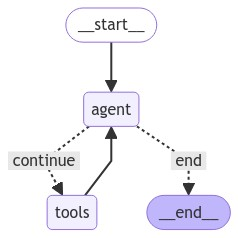

In [ ]:
with suppress(Exception):
    display(Image(graph.get_graph().draw_mermaid_png()))

## Running the Agent

Let's test the agent with a single call

In [ ]:
await graph.ainvoke(
    {
        'messages': [
            {'role': 'user', 'content': 'What sizes do the TinyBirds Wool Runners in Natural Black come in?'}
        ],
        'user_name': user_name,
        'user_node_uuid': user_node_uuid,
    },
    config={'configurable': {'thread_id': uuid.uuid4().hex}},
)

httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
graphiti_core.search.search - INFO - search returned context for query jess: What sizes do the TinyBirds Wool Runners in Natural Black come in? in 245.67198753356934 ms
httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='What sizes do the TinyBirds Wool Runners in Natural Black come in?', id='27dcd1c7-3543-49df-9e53-a884c9376318'),
  AIMessage(content="The TinyBirds Wool Runners in Natural Black are available in size variants 6T, 7T, and 9T. \n\nDo you know your shoe size? Also, are you looking for any specific colors or styles, and what's your budget? I’d love to help you find the perfect pair!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 264, 'total_tokens': 329}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e', 'finish_reason': 'stop', 'logprobs': None}, id='run-f3ab33f2-bdab-4fdf-8fe1-7497302eb922-0', usage_metadata={'input_tokens': 264, 'output_tokens': 65, 'total_tokens': 329})],
 'user_name': 'jess',
 'user_node_uuid': '4a3280321c654ed2a9108f2f30eb515c'}

httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
graphiti_core.utils.maintenance.node_operations - INFO - Extracted new nodes: [{'name': 'jess', 'labels': ['Entity', 'Speaker'], 'summary': 'Jess is the speaker inquiring about the sizes available for the TinyBirds Wool Runners in Natural Black.'}, {'name': 'SalesBot', 'labels': ['Entity', 'Speaker'], 'summary': "SalesBot is the automated assistant responding to Jess's inquiry about shoe sizes and offering further assistance."}, {'name': 'TinyBirds Wool Runners', 'labels': ['Entity', 'Product'], 'summary': 'A type of shoe that Jess is interested in, specifically in the Natural Black color.'}, {'name': 'Natural Black', 'labels': ['Entity', 'Color'], 'summary': 'The color variant of the TinyBirds Wool Runners that Jess is inquiring about.'}] in 2555.851936340332 ms
graphiti_core.utils.maintenance.node_operations - INFO - Created new node: jess (UUID: a94887634375424cbcc7831a949792cb)
graphiti_c

At this stage, the graph would look something like this

The following code will run the agent in an event loop. Just enter a message into the box and click submit.

In [ ]:
# conversation_output = widgets.Output()
# config = {'configurable': {'thread_id': uuid.uuid4().hex}}
# user_state = {'user_name': user_name, 'user_node_uuid': user_node_uuid}


# async def process_input(user_state: State, user_input: str):
#     conversation_output.append_stdout(f'\nUser: {user_input}\n')
#     conversation_output.append_stdout('\nAssistant: ')

#     graph_state = {
#         'messages': [{'role': 'user', 'content': user_input}],
#         'user_name': user_state['user_name'],
#         'user_node_uuid': user_state['user_node_uuid'],
#     }

#     try:
#         async for event in graph.astream(
#             graph_state,
#             config=config,
#         ):
#             for value in event.values():
#                 if 'messages' in value:
#                     last_message = value['messages'][-1]
#                     if isinstance(last_message, AIMessage) and isinstance(
#                         last_message.content, str
#                     ):
#                         conversation_output.append_stdout(last_message.content)
#     except Exception as e:
#         conversation_output.append_stdout(f'Error: {e}')


# def on_submit(b):
#     user_input = input_box.value
#     input_box.value = ''
#     asyncio.create_task(process_input(user_state, user_input))


# input_box = widgets.Text(placeholder='Type your message here...')
# submit_button = widgets.Button(description='Send')
# submit_button.on_click(on_submit)

# conversation_output.append_stdout('Asssistant: Hello, how can I help you find shoes today?')

# display(widgets.VBox([input_box, submit_button, conversation_output]))